In [1]:
import rosbag
import numpy as np
from std_msgs.msg import Int32, String
import matplotlib.pyplot as plt

import rosbag_pandas
import yaml

import warnings
import re
import subprocess
import types

import pandas as pd
import numpy as np

import rospy

%matplotlib notebook

In [2]:
#hard coded function of if statements to get out data we want from bag file
def bag2var(bag, topic):
    
    #create all potential empty lists
    #for tf
    translations_tf_j1 = []
    rotations_tf_j1 = []
    times_tf_j1 = []
    
    translations_tf_j2 = []
    rotations_tf_j2 = []
    times_tf_j2 = []
    
    translations_tf_j3 = []
    rotations_tf_j3 = []
    times_tf_j3 = []
    
    
    #vicon
    positions_vicon = []
    orientations_vicon = []
    times_vicon = []
    
    #robot joint_states
    positions_joints = []
    torques_joints = []
    times_joints = []
    
    #trajectory timing flag
    status_traj = []
    status_times_traj = []
    
    #self defined cycle flag
    cycle_bools = []   
    cycle_times = []
    
    #iterate through, and fill vars based on topic name passed
    for topic, msg, t, in bag.read_messages(topics = [topic]):
        if '/tf' in topic:
            #/tf
            pos = np.array([msg.transforms[0].transform.translation.x, msg.transforms[0].transform.translation.y,
                           msg.transforms[0].transform.translation.z])
            rot = np.array([msg.transforms[0].transform.rotation.w, msg.transforms[0].transform.rotation.x,
                           msg.transforms[0].transform.rotation.y, msg.transforms[0].transform.rotation.z])
            time = msg.transforms[0].header.stamp.to_sec()
            
            frame_id = msg.transforms[0].child_frame_id
            
            if 'j1_dim/base_link' in frame_id:            
                translations_tf_j1.append(pos)
                rotations_tf_j1.append(rot)
                times_tf_j1.append(time)
                
                            
            if 'j2_dim/base_link' in frame_id:            
                translations_tf_j2.append(pos)
                rotations_tf_j2.append(rot)
                times_tf_j2.append(time)
                
                            
            if 'j3_dim/base_link' in frame_id:            
                translations_tf_j3.append(pos)
                rotations_tf_j3.append(rot)
                times_tf_j3.append(time)
            
                           
        if '/vicon/' in topic:
            #/vicon
            pos = np.array([msg.position.x, msg.position.y, msg.position.z])
            rot = np.array([msg.orientation.w, msg.orientation.x, msg.orientation.y, 
                            msg.orientation.z])
            time = msg.header.stamp.to_sec()
            
            positions_vicon.append(pos)
            orientations_vicon.append(rot)
            times_vicon.append(time)
                           
        if '/robot/joint_states' in topic:
            #/joint_states
            if len(msg.name) > 2:  #heuristic to know that we're not getting fingers
                pos = np.array([msg.position])
                torq = np.array([msg.effort])
                time = msg.header.stamp.to_sec()

                positions_joints.append(pos)
                torques_joints.append(torq)
                times_joints.append(time)
                           
        if '/follow_joint_trajectory/status' in topic:
            #/status
            if len(msg.status_list) == 0:
                status_traj.append(0)
            else:
                status = msg.status_list[0].status
                status_traj.append(status)
            status_times_traj.append(msg.header.stamp.to_sec())
                           
        if '/board_pose/cycle_on' in topic:
            #/cycle_on bool
            cycle_bools.append(msg.data)
            
        if '/board_pose/cycle_time' in topic:
            #/cycle_time
            cycle_times.append(msg.data.to_sec())
            
    if '/tf' in topic:
        print "Returning translations, rotations, and timestamps for j1/2/3"
        return (translations_tf_j1, translations_tf_j2, translations_tf_j3, 
                rotations_tf_j1, rotations_tf_j2, rotations_tf_j3,
                times_tf_j1, times_tf_j2, times_tf_j3)
    if '/vicon/' in topic:
        #/vicon
        print "Returning positions, orientations, and timestamps for specified vicon rigid body"
        return positions_vicon, orientations_vicon, times_vicon
    if '/robot/joint_states' in topic:
        #/joint_states
        print "Returning positions and torques of all joints, indexed in order (see Baxter Wiki)"
        return positions_joints, torques_joints, times_joints
    if '/follow_joint_trajectory/status' in topic:
        #/status
        print "Returning trajectory status list with timestamps"
        return status_traj, status_times_traj
    if '/board_pose/cycle_on' in topic:
        #/cycle_on bool
        print "Returning cycle on/off flags"
        return cycle_bools
    if '/board_pose/cycle_time' in topic:
        #/cycle_time
        print "Returning cycle on/off times"
        return cycle_times

In [3]:
def allVarsDict(bag, bag_key, create_dicts=False):
    """
    Input:   bag - rosbag Bag object
             bag_key - key for dictionary 
             
    Output:  Nothing
    
    Functionality: Calls bag2var function for each topic we want and puts them in corresponding dictionaries 
    """
    if create_dicts:
        global j1_pos, j1_rot, j1_time 
        global j2_pos, j2_rot, j2_time 
        global j3_pos, j3_rot, j3_time 
        global joint_angles, joint_torques, joint_times 
        global traj_status, traj_time 
        global cycle_on, cycle_time 
        global tf1_trans, tf1_rot, tf1_time 
        global tf2_trans, tf2_rot, tf2_time 
        global tf3_trans, tf3_rot, tf3_time 
        
        j1_pos, j1_rot, j1_time = {},{},{}
        j2_pos, j2_rot, j2_time = {},{},{}
        j3_pos, j3_rot, j3_time = {},{},{}
        joint_angles, joint_torques, joint_times = {},{},{}
        traj_status, traj_time = {},{}
        cycle_on, cycle_time = {},{}
        tf1_trans, tf1_rot, tf1_time = {},{},{}
        tf2_trans, tf2_rot, tf2_time = {},{},{}
        tf3_trans, tf3_rot, tf3_time = {},{},{}

    print 'getting vicon data...'
    j1_pos[bag_key], j1_rot[bag_key], j1_time[bag_key] = bag2var(bag, '/vicon/j1_dim')
    j2_pos[bag_key], j2_rot[bag_key], j2_time[bag_key] = bag2var(bag, '/vicon/j2_dim')
    j3_pos[bag_key], j3_rot[bag_key], j3_time[bag_key] = bag2var(bag, '/vicon/j3_dim')
    
    print 'getting joint data...'
    joint_angles[bag_key], joint_torques[bag_key], joint_times[bag_key] = bag2var(bag, '/robot/joint_states')
    joint_angles[bag_key] = list(np.array(joint_angles[bag_key]).squeeze())
    joint_torques[bag_key] = list(np.array(joint_torques[bag_key]).squeeze())
    
    print 'getting tf data...'
    tf1_trans[bag_key], tf2_trans[bag_key], tf3_trans[bag_key], tf1_rot[bag_key], tf2_rot[bag_key], tf3_rot[bag_key], tf1_time[bag_key], tf2_time[bag_key], tf3_time[bag_key] = bag2var(bag, '/tf')
    
    print 'getting trajectory and cycle data...'
    traj_status[bag_key], traj_time[bag_key] = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
    cycle_time[bag_key] = bag2var(bag, '/board_pose/cycle_time')
    

In [ ]:
def makeSegmentedDicts():
    #variables for segmented data over many cycles
    global j1_pos_seg, j1_rot_seg, j1_time_seg 
    global j2_pos_seg, j2_rot_seg, j2_time_seg 
    global j3_pos_seg, j3_rot_seg, j3_time_seg 
    global joint_angles_seg, joint_torques_seg, joint_times_seg 
    global tf1_trans_seg, tf1_rot_seg, tf1_time_seg 
    global tf2_trans_seg, tf2_rot_seg, tf2_time_seg 
    global tf3_trans_seg, tf3_rot_seg, tf3_time_seg 

    j1_pos_seg, j1_rot_seg, j1_time_seg = {},{},{}
    j2_pos_seg, j2_rot_seg, j2_time_seg = {},{},{}
    j3_pos_seg, j3_rot_seg, j3_time_seg = {},{},{}
    joint_angles_seg, joint_torques_seg, joint_times_seg = {},{},{}
    tf1_trans_seg, tf1_rot_seg, tf1_time_seg = {},{},{}
    tf2_trans_seg, tf2_rot_seg, tf2_time_seg = {},{},{}
    tf3_trans_seg, tf3_rot_seg, tf3_time_seg = {},{},{}
    
def makeAngleDicts(bag_key, create_dicts=False):
    if create_dicts:
        global r_angles, r_torques  #right joint angles and torques (SEGMENTED)
        global l_angles, l_torques  #left joint angles and torques (SEGMENTED)
        global r_times, l_times
        
        global r_angl

In [4]:
def makeSegmentedDicts():
    #variables for segmented data over many cycles
    global j1_pos_seg, j1_rot_seg, j1_time_seg 
    global j2_pos_seg, j2_rot_seg, j2_time_seg 
    global j3_pos_seg, j3_rot_seg, j3_time_seg 
    global joint_angles_seg, joint_torques_seg, joint_times_seg 
    global tf1_trans_seg, tf1_rot_seg, tf1_time_seg 
    global tf2_trans_seg, tf2_rot_seg, tf2_time_seg 
    global tf3_trans_seg, tf3_rot_seg, tf3_time_seg 

    j1_pos_seg, j1_rot_seg, j1_time_seg = {},{},{}
    j2_pos_seg, j2_rot_seg, j2_time_seg = {},{},{}
    j3_pos_seg, j3_rot_seg, j3_time_seg = {},{},{}
    joint_angles_seg, joint_torques_seg, joint_times_seg = {},{},{}
    tf1_trans_seg, tf1_rot_seg, tf1_time_seg = {},{},{}
    tf2_trans_seg, tf2_rot_seg, tf2_time_seg = {},{},{}
    tf3_trans_seg, tf3_rot_seg, tf3_time_seg = {},{},{}
    
def makeAngleDicts(bag_key, create_dicts=False):
    if create_dicts:
        global r_angles, r_torques  #right joint angles and torques (SEGMENTED)
        global l_angles, l_torques  #left joint angles and torques (SEGMENTED)
        global r_times, l_times
        
        global r_angles_shifted, r_torques_shifted  #right joint angles and torques (SEGMENTED)
        global l_angles_shifted, l_torques_shifted  #left joint angles and torques (SEGMENTED)
        global r_times_shifted, l_times_shifted
        
        r_angles, r_torques, l_angles, l_torques = {},{},{},{}
        r_times, l_times = {},{}
        
        r_angles_shifted, r_torques_shifted, l_angles_shifted, l_torques_shifted = {},{},{},{}
        r_times_shifted, l_times_shifted = {},{}
    
    r_angles[bag_key], l_angles[bag_key], r_torques[bag_key], l_torques[bag_key] = {}, {}, {}, {}
    r_times[bag_key], l_times[bag_key] = {},{}
    
    r_angles_shifted[bag_key], l_angles_shifted[bag_key], r_torques_shifted[bag_key], l_torques_shifted[bag_key] = {}, {}, {}, {}
    r_times_shifted[bag_key], l_times_shifted[bag_key] = {},{}
    
def makeJointAngleNames(bag):
    names = None
    #grab list of joint names from /robot/joint_states topic
    for topic, msg, t in bag1.read_messages(topics = ['/robot/joint_states']):
        if (names is not None):
            break
        if len(msg.name) > 3:  #check so we don't get finger joints
            names = msg.name
    
    #map to key value in dictionary
    unpack = []
    for i in range(len(names)):
        unpack.append([names[i], i])
    joint_dict = {key: value for (key, value) in unpack}  
            
    return names, joint_dict

In [5]:
#get all data we're currently interested in out     
def allvars(bag):
    global j1_pos, j1_rot, j1_time
    global j2_pos, j2_rot, j2_time
    global j3_pos, j3_rot, j3_time
    global joint_angles, joint_torques, joint_times
    global traj_status, traj_time
    global cycle_on, cycle_time
    global tf1_trans, tf1_rot, tf1_time
    global tf2_trans, tf2_rot, tf2_time
    global tf3_trans, tf3_rot, tf3_time    
    
    print 'getting vicon data...'
    j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
    j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
    j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')
    
    print 'getting joint data...'
    joint_angles, joint_torques, joint_times = bag2var(bag, '/robot/joint_states')
    joint_angles = list(np.array(joint_angles).squeeze())
    joint_torques = list(np.array(joint_torques).squeeze())
    
    print 'getting tf data...'
    tf1_trans, tf2_trans, tf3trans, tf1_rot, tf2_rot, tf3_rot, tf1_time, tf2_time, tf3_time = bag2var(bag, '/tf')
    
    print 'getting trajectory and cycle data...'
    traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
    cycle_time = bag2var(bag, '/board_pose/cycle_time')

In [6]:
def segmentCycles(cycle_t, data_t, data):
    """
    
    input: 
      cycle_t - time vector of start/stop times of repeated cycles
      data_t - vector of timestamps corresponding to data points
      data - data vector (should be same length as data_t)
    
    output: 
      data_cycled - list of lists, where first dimension corresponds to cycle number
      data_t_cycles - same as above but for timesteps
    
    function: 
      goes get indices of data_t which are closest to those in cycle_t, and then splits up data accordingly
    
    """
    
    #make all numpy arrays
    cycle_t = np.array(cycle_t)
    data_t = np.array(data_t)
    data = np.array(data)
    
    #index to the 0 at start of times
    cycle_t -= cycle_t[0].copy()
    data_t -= data_t[0].copy()
    
    #lowpass filter the data TODO
    
    #make repeated matrix to perform column wise subtraction and get errors to minimize
    rep_data_t = np.repeat(data_t[:, np.newaxis], cycle_t.shape[0], axis=1)
    delta_t = rep_data_t - cycle_t
    error_t = delta_t * delta_t
    idx_t = np.argmin(error_t, axis=0)
    
    print "Best index matches based on time stamps:"
    print idx_t
    
    #use idx_t to go through data and separate based on cycles
    data_cycled = []
    data_t_cycled = []
    if len(idx_t) % 2 == 0:
        for i in range(1, len(idx_t)/2):
            data_cycled.append(data[idx_t[i*2]:idx_t[i*2+1]])
            data_t_cycled.append(data_t[idx_t[i*2]:idx_t[i*2+1]] - data_t[idx_t[i*2]])
    else:
        for i in range(1, len(idx_t)/2):
            data_cycled.append(data[idx_t[i*2]:idx_t[i*2+1]])
            data_t_cycled.append(data_t[idx_t[i*2]:idx_t[i*2+1]] - data_t[idx_t[i*2]])        
    
    return data_cycled, data_t_cycled

In [58]:
def plotSegmentedRaw(data, time, topic):
    color_idx = np.linspace(0, 1, len(data))
    run_num = np.arange(len(data))
    plt.figure()
    if len(data[0]) == 3:
        for i, col in zip(range(len(data)), color_idx):
            plt.subplot(311)
            plt.plot(time[i][:,0], data[i][:,0], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

            plt.subplot(312)
            plt.plot(time[i][:,1], data[i][:,1], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

            plt.subplot(313)
            plt.plot(time[i][:,2], data[i][:,2], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
    else:        
        for i, col in zip(range(len(data)), color_idx):
#             plt.plot(time[i], data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
            plt.plot(data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
                
#     plt.legend()
    plt.show()
    
def plotSegmentedJoints(data_full, time_full, joint_list, data_type=None):
    fig = plt.figure()
    for j in range(len(joint_list)):
        #make subplot and index through
        plt.subplot(len(joint_list), 1, j+1)
        
        #create local data vector for individual joint
        data = data_full[joint_list[j]]
        time = time_full[joint_list[j]]
        
        #do plotting on particular subplot
        color_idx = np.linspace(0, 1, len(data))
        run_num = np.arange(len(data))
        if len(data[0]) == 3:
            for i, col in zip(range(len(data)), color_idx):
                plt.subplot(311)
                plt.plot(time[i][:,0], data[i][:,0], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

                plt.subplot(312)
                plt.plot(time[i][:,1], data[i][:,1], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

                plt.subplot(313)
                plt.plot(time[i][:,2], data[i][:,2], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
        else:        
            for i, col in zip(range(len(data)), color_idx):
    #             plt.plot(time[i], data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
                plt.plot(data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

        plt.title(joint_list[j])
        if 'angle' in data_type:
            plt.ylabel('rad')
        if 'torque' in data_type:
            plt.ylabel('Nm')
#     plt.legend()
    plt.show()
    return fig

In [86]:
#use cross correlation to find time delay between two signals

def shiftSignals(data, time, left_start=True, right_end=False):
    
    shifted_data = []
    shifted_time = []
    
    if left_start:
        ind_first = []
        for i in range(len(data)):
            #new epsilon for each cycle
            epsilon = np.array([data[i][0]*1.5], dtype=float)
            
            #make array checking location of first deviation from start, after zeroing data
            where_array = np.argwhere((np.abs(data[i] - data[i][0])) > abs(epsilon-data[i][0]))
            while len(where_array) == 0:
                #if deltas are too small, decrease the epsilon
                epsilon = epsilon*0.9
                where_array = np.argwhere((np.abs(data[i] - data[i][0])) > abs(epsilon-data[i][0]))
            first = where_array[0][0]
            ind_first.append(first)
        early_run = np.argmin(ind_first)
        print "most left shifted cycle:"
        print early_run

        for i in range(len(data)):
            if i == early_run:
                shifted_data.append(data[i])
            else:
                ti = np.abs(np.correlate(data[early_run], data[i], 'full'))
                shift = len(data[i]) - np.argmax(ti)
                shifted_data.append(data[i][shift:])
                shifted_time.append(time[i][shift:] - time[i][shift])
        return shifted_data, shifted_time
    
    elif right_end:
        ind_last = []
        for i in range(len(data)):
            last = np.argwhere(np.abs(data[i]) > abs(epsilon))[-1][0]
            ind_last.append(last)
        last_run = np.argmax(ind_last)
        print "most right shifted cycle:"
        print last_run
        
        for i in range(len(data)):
            if i == last_run:
                shifted_data.append(data[i])
            else:
                ti = np.abs(np.correlate(data[last_run], data[i], 'full'))
                shift = len(data[last_run]) - np.argmax(ti)
                shifted_data.append(np.array(np.insert(data[i], 0, shift*[data[i][0]])))
                #TODO get time data shifted too
        return shifted_data, shifted_time
    else:
        print "Please input left shift or right shift"
        return -1
    
def shiftJointSignals(data_full, time_full, joint_list, left_start=True, right_end=False):
    shifted_data = {}
    shifted_time = {}
    for j in range(len(joint_list)):
        #create local data vector for individual joint
        data = data_full[joint_list[j]]
        time = time_full[joint_list[j]]
        print j
        shifted_data[joint_list[j]], shifted_time[joint_list[j]] = shiftSignals(data, time, left_start, right_end)
    
    return shifted_data, shifted_time 
    

In [24]:
#load bag into memory as Bag object
#one joint
bag1 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/one_joint_one_bag.bag')
bag2 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/one_joint_two_bag.bag')

#two joints
# bag1 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/two_joint_one_bag.bag')
# bag2 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/two_joint_two_bag.bag')
bag1key = 'two_1'
bag2key = 'two_2'

In [25]:
#use yaml to make dictionary of info
info_dict = yaml.load(bag1._get_yaml_info())

#index through to make a list of topic names
topic_list = []
for i in range(len(info_dict['topics'])):
    topic_list.append([info_dict['topics'][i]['topic'], i])  
    
print "Topics in Bagfile:   "
print topic_list

Topics in Bagfile:   
[['/board_pose/cycle_on', 0], ['/board_pose/cycle_time', 1], ['/robot/joint_states', 2], ['/robot/limb/right/follow_joint_trajectory/status', 3], ['/tf', 4], ['/vicon/j1_dim', 5], ['/vicon/j2_dim', 6], ['/vicon/j3_dim', 7]]


In [26]:
# run allVarsDict(bag, bag_key, create_dicts=True/False) to get all global variables for plotting and analysis, or get individual variables

allVarsDict(bag1, bag_key=bag1key, create_dicts=True)
allVarsDict(bag2, bag_key=bag2key, create_dicts=False)

# traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
# cycle_time = bag2var(bag, '/board_pose/cycle_time')

# joint_angles_t, joint_torques_t, joint_times_t = bag2var(bag, '/robot/joint_states')
# joint_angles = list(np.array(joint_angles).squeeze())
# joint_torques = list(np.array(joint_torques).squeeze())

# j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
# j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
# j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')

# tf_trans, tf_rot, tf_time = bag2var(bag, '/tf')

getting vicon data...
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
getting joint data...
Returning positions and torques of all joints, indexed in order (see Baxter Wiki)
getting tf data...
Returning translations, rotations, and timestamps for j1_base_link
getting trajectory and cycle data...
Returning trajectory status list with timestamps
Returning cycle on/off times
getting vicon data...
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
getting joint data...
Returning positions and torques of all joints, indexed in order (see Baxter Wiki)
getting tf data...
Returning translations, rotations, and tim

In [45]:
makeSegmentedDicts()
makeAngleDicts(bag1key, create_dicts=True)
makeAngleDicts(bag2key, create_dicts=False)
joint_list, joint_dict = makeJointAngleNames(bag1)

right_joints = ['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']
left_joints = ['left_s0', 'left_s1', 'left_e0', 'left_e1', 'left_w0', 'left_w1', 'left_w2']


# right now want right s0/s1/e0/e1/w0/w1/w2 - 1,8
for i in range(len(right_joints)):
    r_angles[bag1key][right_joints[i]], r_times[bag1key][right_joints[i]] = (
            segmentCycles(cycle_t=cycle_time[bag1key], 
                          data_t=joint_times[bag1key], 
                          data=list(np.array(joint_angles[bag1key])[:,joint_dict[right_joints[i]]])
                         )
    )
    
for i in range(len(right_joints)):
    r_torques[bag1key][right_joints[i]], r_times[bag1key][right_joints[i]] = (
            segmentCycles(cycle_t=cycle_time[bag1key], 
                          data_t=joint_times[bag1key], 
                          data=list(np.array(joint_torques[bag1key])[:,joint_dict[right_joints[i]]])
                         )
    )

# joint_torques_seg['two_1'], joint_times_seg['two_1'] = segmentCycles(cycle_t=cycle_time['two_1'], data_t=joint_times['two_1'], data=list(np.array(joint_torques['two_1'])[:,12]))


Best index matches based on time stamps:
[    0  1603  1607  4255  4258  6767  6771  9355  9359 11929 11932 14480
 14484 17052 17054 19630 19634 22163 22166 24898 24900 27470 27473 29998
 30001 32677 32680 35257 35261 37850 37853 40411 40415 43000 43004 45626
 45629 48192 48195 50730]
Best index matches based on time stamps:
[    0  1603  1607  4255  4258  6767  6771  9355  9359 11929 11932 14480
 14484 17052 17054 19630 19634 22163 22166 24898 24900 27470 27473 29998
 30001 32677 32680 35257 35261 37850 37853 40411 40415 43000 43004 45626
 45629 48192 48195 50730]
Best index matches based on time stamps:
[    0  1603  1607  4255  4258  6767  6771  9355  9359 11929 11932 14480
 14484 17052 17054 19630 19634 22163 22166 24898 24900 27470 27473 29998
 30001 32677 32680 35257 35261 37850 37853 40411 40415 43000 43004 45626
 45629 48192 48195 50730]
Best index matches based on time stamps:
[    0  1603  1607  4255  4258  6767  6771  9355  9359 11929 11932 14480
 14484 17052 17054 19630 196

<IPython.core.display.Javascript object>


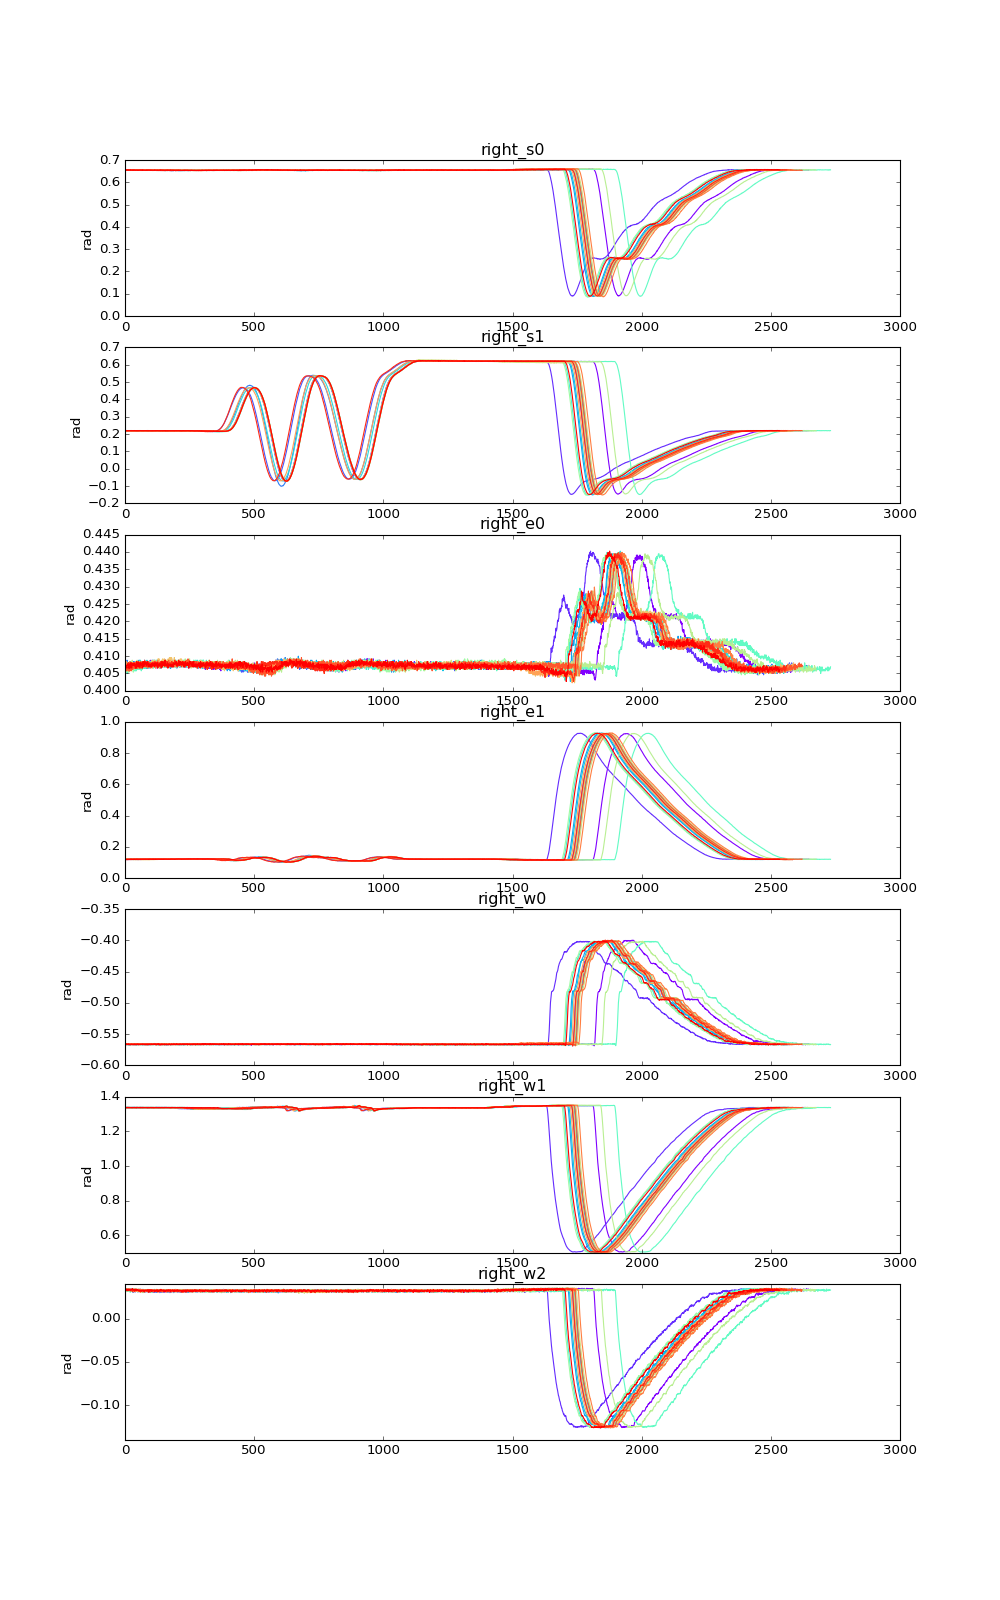

In [59]:
%matplotlib notebook

fig1_raw = plotSegmentedJoints(data_full=r_angles[bag1key], time_full=r_times[bag1key], joint_list=right_joints, data_type='angles')
fig1_raw.set_size_inches(12.5, 20, forward=True)



# plotSegmentedRaw(r_angles[bag1key][right_joints[i]], r_times[bag1key][right_joints[i]], 'test')
# plt.close()

<IPython.core.display.Javascript object>


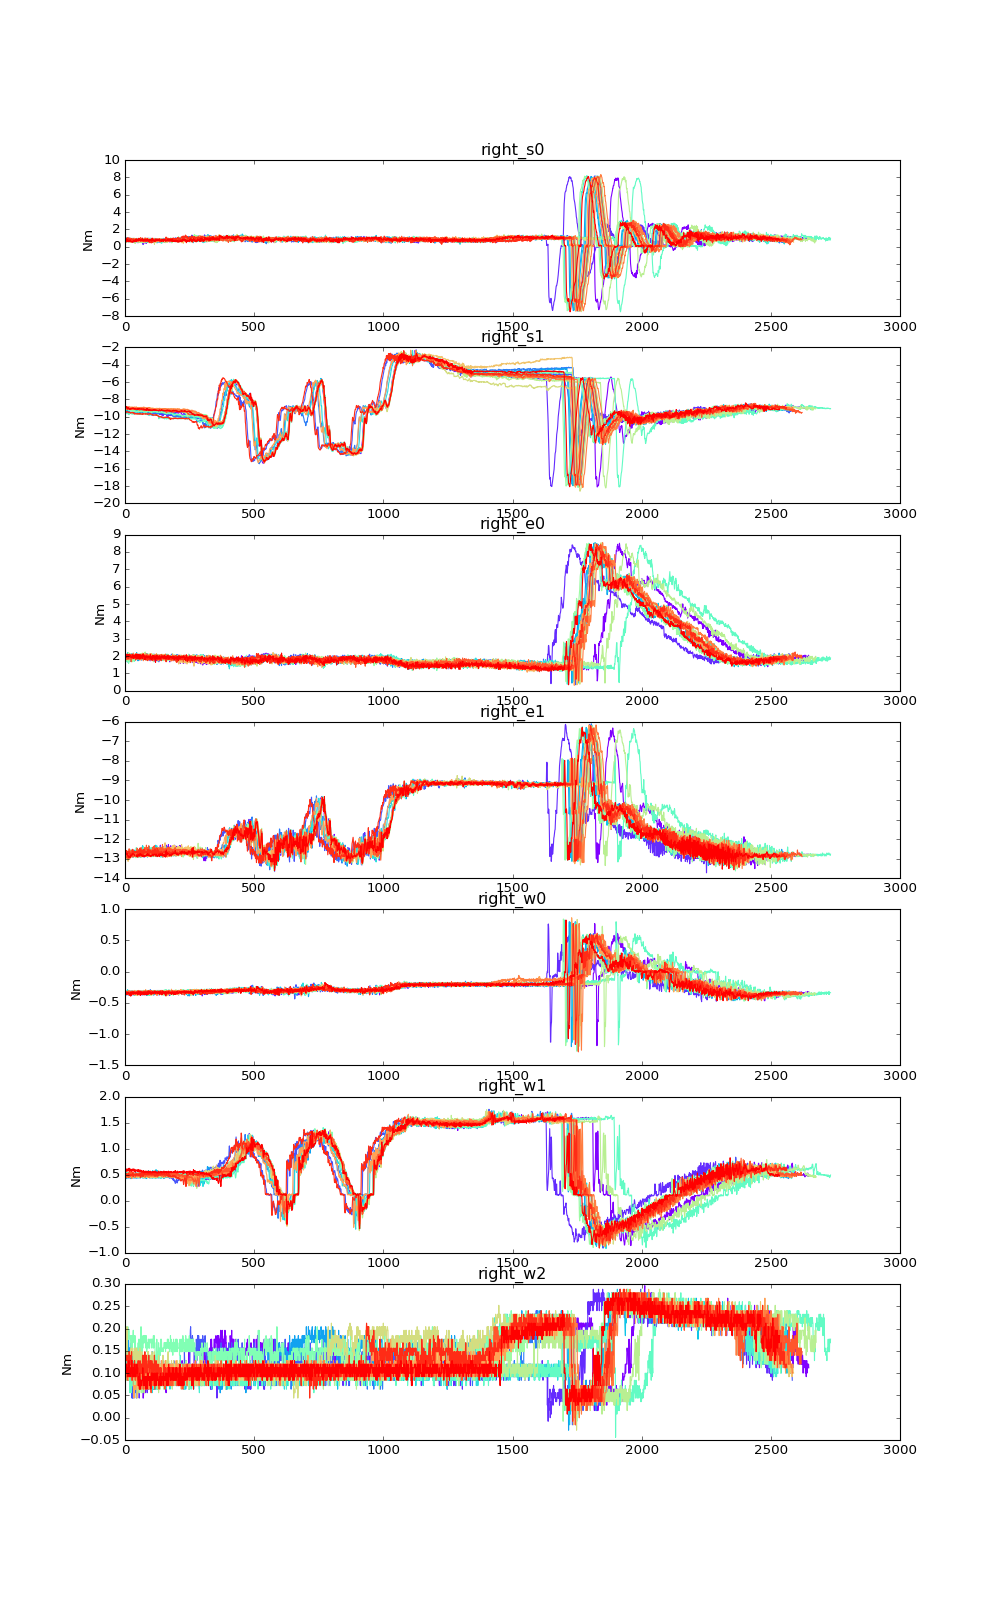

In [60]:
fig2_raw = plotSegmentedJoints(data_full=r_torques[bag1key], time_full=r_times[bag1key], joint_list=right_joints, data_type='torque')
fig2_raw.set_size_inches(12.5, 20, forward=True)

In [87]:
r_angles_shifted, r_torques_shifted, l_angles_shifted, l_torques_shifted = {},{},{},{}
r_times_shifted, l_times_shifted = {},{}

print right_joints

r_angles_shifted[bag1key], r_times_shifted[bag1key] = (
    shiftJointSignals(
        data_full=r_angles[bag1key], 
        time_full=r_times[bag1key],
        joint_list=right_joints)
)


# shifted_joint_torques_seg, shifted_joint_times_seg = shiftSignals(joint_torques_seg, joint_times_seg)
# for i in range(len(shifted_joint_torques_seg)):
#     print len(shifted_joint_torques_seg[i]), len(shifted_joint_times_seg[i])
    


['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']
0
most left shifted cycle:
1
1
most left shifted cycle:
2
2
most left shifted cycle:
1
3
most left shifted cycle:
1
4
most left shifted cycle:
1
5
most left shifted cycle:
1
6
most left shifted cycle:
1


<IPython.core.display.Javascript object>


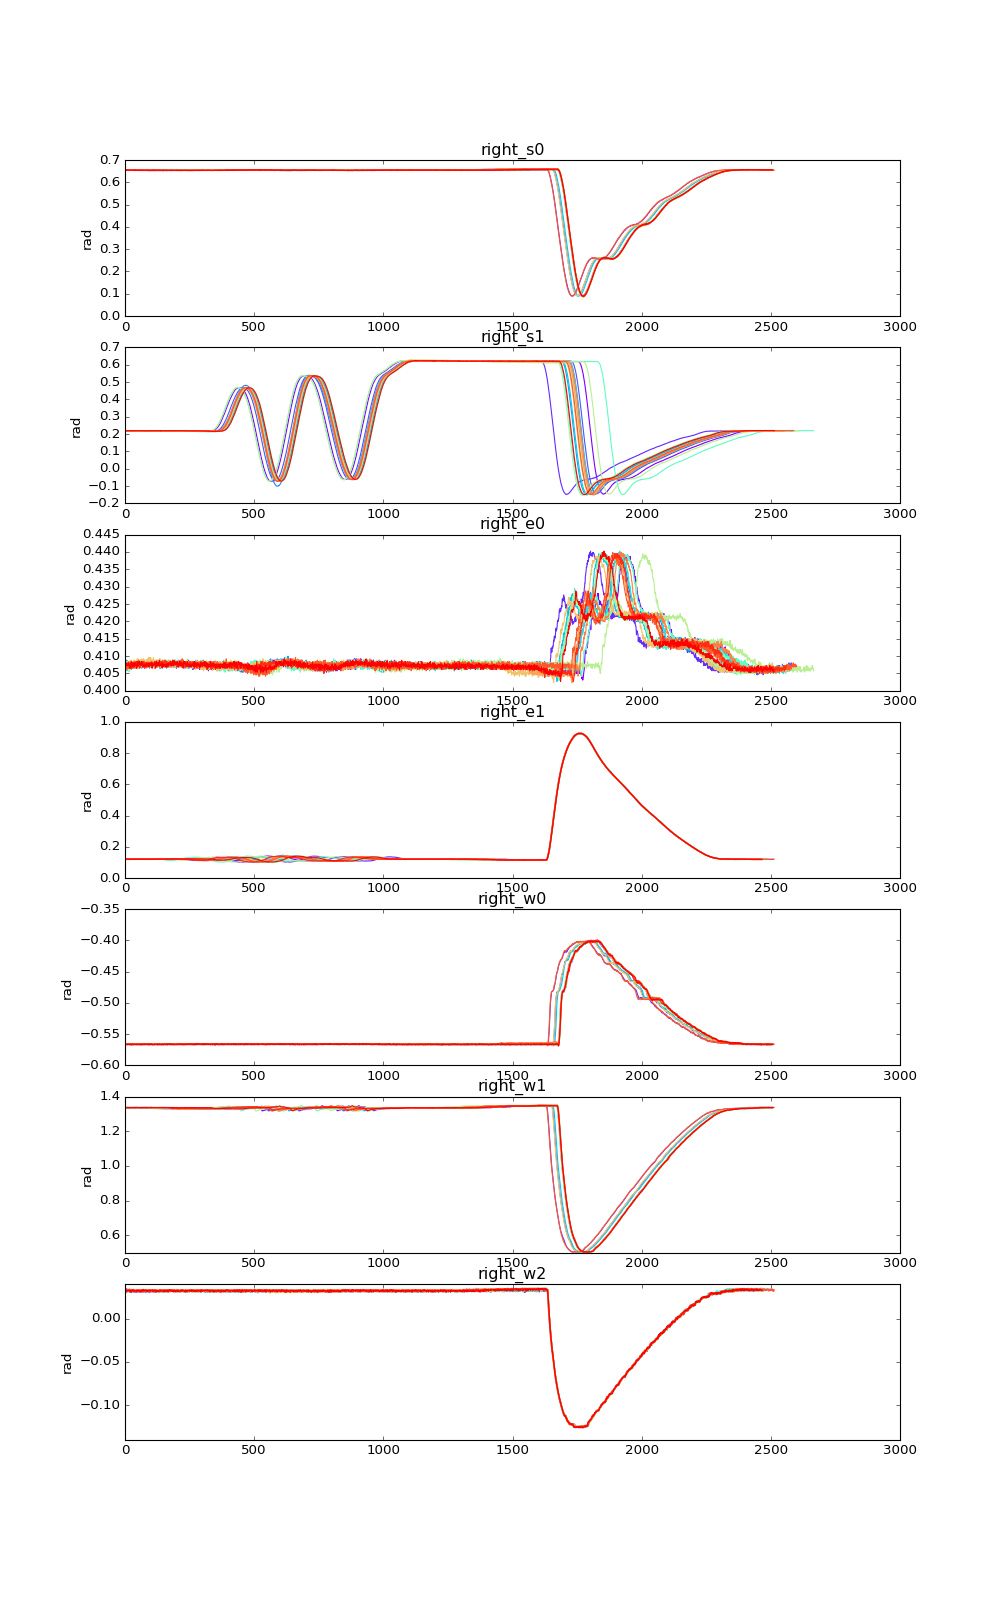

In [89]:
fig1_shift = plotSegmentedJoints(data_full=r_angles_shifted[bag1key], time_full=r_times_shifted[bag1key], joint_list=right_joints, data_type='angles')
fig1_shift.set_size_inches(12.5, 20, forward=True)
# plt.close()

[  0.      0.      0.028  -2.004   0.248  -0.12    0.272   0.276   0.448
   2.268 -11.792   0.34   -7.216  -0.108  -0.568   0.176 -20.48 ]


In [ ]:
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

#import R objects and dtw library functions
R = rpy2.robjects.r
DTW = importr('dtw')

In [ ]:
#save data nicely
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_angles', joint_angles, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_torques', joint_torques, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_times', joint_times, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_angles_segmented', joint_angles_seg, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_times_segmented', joint_times_seg, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/shifted_joint_angles_segmented', shifted_joint_angles_seg, allow_pickle=True)


In [19]:
# print len(r_angles[bag1key]['right_s1'][0])
print r_angles[bag1key]['right_s1']
print r_torques[bag1key]['right_s1']
print r_times[bag1key]['right_s1']

[array([ -7.188,  -7.276,  -7.332, ..., -10.68 , -10.596, -10.624]), array([-10.536, -10.596, -10.652, ..., -10.624, -10.74 , -10.796]), array([-10.304, -10.36 , -10.476, ...,  -9.72 ,  -9.46 ,  -9.224]), array([ -8.904,  -8.584,  -7.888, ..., -17.056, -17.   , -16.912]), array([-17.32 , -17.288, -17.32 , ..., -15.136, -15.108, -15.108]), array([-15.456, -15.572, -15.6  , ..., -18.572, -18.572, -18.772]), array([-18.6  , -18.452, -18.396, ..., -10.596, -10.536, -10.652]), array([-10.68 , -10.652, -10.596, ...,  -7.452,  -7.48 ,  -7.652]), array([ -8.004,  -8.236,  -8.412, ..., -15.252, -15.34 , -15.396]), array([-15.716, -15.66 , -15.632, ..., -18.452, -18.396, -18.424]), array([-18.512, -18.688, -18.512, ...,  -7.624,  -7.596,  -7.684]), array([ -8.264,  -8.324,  -8.296, ..., -12.048, -12.456, -12.66 ]), array([-12.544, -12.312, -12.252, ..., -15.716, -15.776, -15.776]), array([-15.748, -15.716, -15.688, ..., -16.532, -16.532, -16.476]), array([-17.028, -17.028, -17.084, ..., -10.712,

KeyError: 'right_s1'

In [ ]:
#prototype stuff here

# print j1_time[-1]
# print j2_time[-1]
# print j3_time[-1]
# print tf_time[-1]
# print traj_time[-1]
# print cycle_time[-1]
# print joint_times[-1]

# print j1_time[0]
# print j2_time[0]
# print j3_time[0]
# print tf_time[0]
# print traj_time[0]
# print cycle_time[0]
# print joint_times[0]


t0 = np.abs(np.correlate(test_data[12], test_data[0], 'full'))
t1 = np.abs(np.correlate(test_data[12], test_data[1], 'full'))

print len(test_data[12]), len(test_data[0]), len(test_data[1])
print t0
print t1
print np.argmax(t0)
print np.argmax(t1)
print len(t0)
print len(t1)
print len(t0) - np.argmax(t0)
print len(t1) - np.argmax(t1)

print np.argmax(t0) - len(test_data[12])
print np.argmax(t1) - len(test_data[12])

# plt.figure(2)
# plt.plot(test_data[12])
# plt.plot(test_data[0][:])
# plt.plot(test_data[1][:])
# plt.legend(['late (12)', '0', '1'])
# plt.show()

plt.figure(2)
plt.plot(test_data[12])
plt.plot(np.insert(test_data[0][:], 0, [test_data[0][0]]*522))
plt.plot(np.insert(test_data[1][:], 0, [test_data[0][0]]*470))
plt.legend(['late (12)', '0', '1'])
plt.show()

In [20]:
# print df.columns
# print rosbag_pandas.get_bag_info('one_joint_one_bag.bag')
# print bag.read_messages(topics = '/tf')
num_msgs = 500
test_list = []
for topic, msg, t in bag1.read_messages(topics = ['/robot/joint_states']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

header: 
  seq: 20131021
  stamp: 
    secs: 1519615004
    nsecs: 239217850
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.38656315854712425, -0.021859226227367145, 0.7202039799122018, 1.2613157028387814, 0.7719758315033345, 1.132844811853378, 0.05138835639416136, 1.5577574900976376, 0.4076553943805487, 0.1794757521825934, 0.3347913069559916, 0.42299520225940285, -0.5330583237901813, 0.6703496043059258, 0.10431069357620813, -12.565987119160338]
velocity: [0.0, 0.0027488935713754254, -0.0035342917346255468, -0.003141592653000486, -0.012173671530376884, 0.006283185306000972, 0.013351768775252066, 0.011388273367126762, 0.005890486224375911, 0.0035342917346255468, 0.0047123889795007284, -0.00039269908162506076, 0.00510508806112579, 0.005890486224375911, -0.014137166938502187, 0.0023561944897503642, 0.0]
effort: [0.0, 0.0, 0.028, -2.

header: 
  seq: 20131130
  stamp: 
    secs: 1519615005
    nsecs: 329196791
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.38656315854712425, -0.022626216621309852, 0.7213544655031158, 1.2601652172478675, 0.7712088411093918, 1.1324613166564066, 0.05177185159113271, 1.5573739949006664, 0.4076553943805487, 0.17909225698562206, 0.3351748021529629, 0.42299520225940285, -0.5330583237901813, 0.6707330995028972, 0.10354370318226543, -12.565987119160338]
velocity: [0.0, -0.0070685834692510935, -0.01531526418337737, -0.0070685834692510935, -0.00039269908162506076, 0.005497787142750851, -0.0047123889795007284, 0.01021017612225158, -0.0019634954081253035, 0.007853981632501214, -0.0007853981632501215, -0.010995574285501701, 0.009817477040626518, 0.008246680714126275, -0.031415926530004856, 0.012566370612001944, 0.0]
effort: [0.0, 0.0, 0.092

header: 
  seq: 20131238
  stamp: 
    secs: 1519615006
    nsecs: 409218290
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.3869466537440956, -0.02147573103039579, 0.7217379607000872, 1.2609322076418101, 0.7719758315033345, 1.131694326262464, 0.052155346788104066, 1.5577574900976376, 0.40803888957752005, 0.17909225698562206, 0.33555829734993425, 0.42299520225940285, -0.5338253141841239, 0.6703496043059258, 0.10316020798529407, -12.565987119160338]
velocity: [0.0, 0.010995574285501701, -0.007853981632501214, -0.014137166938502187, -0.011388273367126762, -0.011388273367126762, -0.0047123889795007284, 0.005890486224375911, 0.0019634954081253035, 0.036128315509505585, -0.003141592653000486, -0.003926990816250607, 0.009032078877376396, -0.013351768775252066, 0.011388273367126762, 0.019634954081253035, 0.0]
effort: [0.0, 0.0, 0.092, -2

header: 
  seq: 7981715
  stamp: 
    secs: 1519615007
    nsecs: 328999936
  frame_id: ''
name: [r_gripper_l_finger_joint]
position: [0.02083]
velocity: [0.0]
effort: [0.0]
header: 
  seq: 7981716
  stamp: 
    secs: 1519615007
    nsecs: 368999936
  frame_id: ''
name: [l_gripper_l_finger_joint]
position: [0.02083]
velocity: [0.0]
effort: [0.0]
header: 
  seq: 7981717
  stamp: 
    secs: 1519615007
    nsecs: 380000000
  frame_id: ''
name: [r_gripper_l_finger_joint]
position: [0.02083]
velocity: [0.0]
effort: [0.0]
header: 
  seq: 20131336
  stamp: 
    secs: 1519615007
    nsecs: 389198778
  frame_id: ''
name: [head_nod, head_pan, left_e0, left_e1, left_s0, left_s1, left_w0, left_w1, left_w2,
  right_e0, right_e1, right_s0, right_s1, right_w0, right_w1, right_w2, torso_t0]
position: [0.0, -0.387330148941067, -0.021859226227367145, 0.7209709703061444, 1.2613157028387814, 0.7723593267003058, 1.1320778214594354, 0.05177185159113271, 1.5577574900976376, 0.406888403986606, 0.1787087617886

In [ ]:
num_msgs = 500
test_list = []
for topic, msg, t in bag.read_messages(topics = ['/board_pose/cycle_time']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

In [ ]:
class Baxter_Data_Analysis(topics):
    def __init__(self):
        self.topics = topics
        self.date
        self.
    
    self.known_topics = ['/board_pose/cycle_on', '/board_pose/cycle_time', '/robot/joint_states',
                         '/robot/limb/right/follow_joint_trajectory/status',
                         '/tf', '/vicon/j1_dim', '/vicon/j2_dim', '/vicon/j3_dim']
